In [1]:
# to access functions from root directory
import sys
sys.path.append('/data/ad181/RemoteDir/ada_multigrid_ppo')

In [2]:
%matplotlib notebook
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
from copy import copy, deepcopy

import gym
from stable_baselines3.ppo import PPO, MlpPolicy
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.callbacks import CallbackList
from utils.custom_eval_callback import CustomEvalCallback, CustomEvalCallbackParallel
from utils.env_wrappers import StateCoarse, BufferWrapper, EnvCoarseWrapper, StateCoarseMultiGrid
from typing import Callable
from utils.plot_functions import plot_learning
from utils.multigrid_framework_functions import env_wrappers_multigrid, make_env, generate_beta_environement, parallalize_env, multigrid_framework

from model.ressim import Grid
from ressim_env import ResSimEnv_v0, ResSimEnv_v1

/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/co

In [3]:
seed=1
case='case_1_singlegrid_quarter'
data_dir='./data'
log_dir='./data/'+case

In [4]:
os.makedirs(data_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

In [5]:
with open('../envs_params/env_data/env_train.pkl', 'rb') as input:
    env_train = pickle.load(input)

# define RL model and callbacks

In [6]:
def generate_model(env_train, seed):
    dummy_env =  generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    dummy_env_parallel = parallalize_env(dummy_env, num_actor=64, seed=seed)
    model = PPO(policy=MlpPolicy,
                env=dummy_env_parallel,
                learning_rate = 3e-6,
                n_steps = 40,
                batch_size = 16,
                n_epochs = 20,
                gamma = 0.99,
                gae_lambda = 0.95,
                clip_range = 0.1,
                clip_range_vf = None,
                ent_coef = 0.001,
                vf_coef = 0.5,
                max_grad_norm = 0.5,
                use_sde= False,
                create_eval_env= False,
                policy_kwargs = dict(net_arch=[150,100,80], log_std_init=-2.9),
                verbose = 1,
                target_kl = 0.05,
                seed = seed,
                device = "auto")
    return model

def generate_callback(env_train, best_model_save_path, log_path, eval_freq):
    dummy_env = generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    callback = CustomEvalCallbackParallel(dummy_env, 
                                          best_model_save_path=best_model_save_path, 
                                          n_eval_episodes=1,
                                          log_path=log_path, 
                                          eval_freq=eval_freq)
    return callback

# multigrid framework

Using cuda device
seed 1: grid fidelity factor 0.25 learning ..
environement grid size (nx x ny ): 15 x 15


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7fbdbe8ca2e8> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7fbdbcc850f0>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.59 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------
| eval/              |          |
|    mean_ep_length  | 5        |
|    mean_reward     | 0.594    |
| time/              |          |
|    fps             | 200      |
|    iterations      | 1        |
|    time_elapsed    | 12       |
|    total_timesteps | 2560     |
---------------------------------
policy iteration runtime: 37 seconds

Total episode rollouts: 512

Eval num_timesteps=2560, episode_reward=0.60 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.597       |
| time/                   |             |
|    fps                  | 210         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| t

policy iteration runtime: 34 seconds

Total episode rollouts: 4608

Eval num_timesteps=2560, episode_reward=0.61 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.614       |
| time/                   |             |
|    fps                  | 208         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008558616 |
|    clip_fraction        | 0.331       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.785       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0711      |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.0256     |
|    std                  | 

policy iteration runtime: 34 seconds

Total episode rollouts: 8704

Eval num_timesteps=2560, episode_reward=0.64 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.638       |
| time/                   |             |
|    fps                  | 200         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.009073767 |
|    clip_fraction        | 0.344       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.85        |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0319      |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.0259     |
|    std                  | 

policy iteration runtime: 38 seconds

Total episode rollouts: 12800

Eval num_timesteps=2560, episode_reward=0.66 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.655        |
| time/                   |              |
|    fps                  | 203          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0019960166 |
|    clip_fraction        | 0.345        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.864        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0468       |
|    n_updates            | 500          |
|    policy_gradient_loss | -0.0268      |
|    std

policy iteration runtime: 34 seconds

Total episode rollouts: 16896

Eval num_timesteps=2560, episode_reward=0.66 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.661      |
| time/                   |            |
|    fps                  | 212        |
|    iterations           | 1          |
|    time_elapsed         | 12         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.00624949 |
|    clip_fraction        | 0.347      |
|    clip_range           | 0.1        |
|    entropy_loss         | 91.8       |
|    explained_variance   | 0.883      |
|    learning_rate        | 3e-06      |
|    loss                 | 0.0381     |
|    n_updates            | 660        |
|    policy_gradient_loss | -0.0278    |
|    std                  | 0.0551     |
|    value_loss           |

policy iteration runtime: 35 seconds

Total episode rollouts: 20992

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.669        |
| time/                   |              |
|    fps                  | 210          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0063076317 |
|    clip_fraction        | 0.352        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.889        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0548       |
|    n_updates            | 820          |
|    policy_gradient_loss | -0.0267      |
|    std

policy iteration runtime: 35 seconds

Total episode rollouts: 25088

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.673        |
| time/                   |              |
|    fps                  | 213          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0042487443 |
|    clip_fraction        | 0.347        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.906        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0587       |
|    n_updates            | 980          |
|    policy_gradient_loss | -0.0264      |
|    std                  | 0.

policy iteration runtime: 40 seconds

Total episode rollouts: 29184

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.677        |
| time/                   |              |
|    fps                  | 210          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0065386416 |
|    clip_fraction        | 0.356        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.899        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0364       |
|    n_updates            | 1140         |
|    policy_gradient_loss | -0.0277      |
|    std

policy iteration runtime: 40 seconds

Total episode rollouts: 33280

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.679        |
| time/                   |              |
|    fps                  | 209          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0066307215 |
|    clip_fraction        | 0.355        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.913        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0712       |
|    n_updates            | 1300         |
|    policy_gradient_loss | -0.0283      |
|    std                  | 0.

policy iteration runtime: 42 seconds

Total episode rollouts: 37376

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.68        |
| time/                   |             |
|    fps                  | 213         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.003269437 |
|    clip_fraction        | 0.364       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.904       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0537      |
|    n_updates            | 1460        |
|    policy_gradient_loss | -0.0277     |
|    std                  |

policy iteration runtime: 34 seconds

Total episode rollouts: 41472

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.679       |
| time/                   |             |
|    fps                  | 206         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007336679 |
|    clip_fraction        | 0.357       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.905       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0328      |
|    n_updates            | 1620        |
|    policy_gradient_loss | -0.0279     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 34 seconds

Total episode rollouts: 45568

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.68        |
| time/                   |             |
|    fps                  | 211         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007523045 |
|    clip_fraction        | 0.37        |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.914       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0469      |
|    n_updates            | 1780        |
|    policy_gradient_loss | -0.0292     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 34 seconds

Total episode rollouts: 49664

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.68         |
| time/                   |              |
|    fps                  | 213          |
|    iterations           | 1            |
|    time_elapsed         | 11           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0042429743 |
|    clip_fraction        | 0.386        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.916        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0468       |
|    n_updates            | 1940         |
|    policy_gradient_loss | -0.0296      |
|    std                  | 0.

policy iteration runtime: 34 seconds

Total episode rollouts: 53760

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.68        |
| time/                   |             |
|    fps                  | 213         |
|    iterations           | 1           |
|    time_elapsed         | 11          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.009703982 |
|    clip_fraction        | 0.364       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.92        |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0379      |
|    n_updates            | 2100        |
|    policy_gradient_loss | -0.0283     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 32 seconds

Total episode rollouts: 57856

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.68        |
| time/                   |             |
|    fps                  | 210         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008864725 |
|    clip_fraction        | 0.373       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.908       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0514      |
|    n_updates            | 2260        |
|    policy_gradient_loss | -0.0276     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 35 seconds

Total episode rollouts: 61952

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.681       |
| time/                   |             |
|    fps                  | 206         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.012013653 |
|    clip_fraction        | 0.374       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.918       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.043       |
|    n_updates            | 2420        |
|    policy_gradient_loss | -0.0287     |
|    std                  |

policy iteration runtime: 41 seconds

Total episode rollouts: 66048

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.681        |
| time/                   |              |
|    fps                  | 210          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0030129552 |
|    clip_fraction        | 0.379        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.9         |
|    explained_variance   | 0.916        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0511       |
|    n_updates            | 2580         |
|    policy_gradient_loss | -0.0275      |
|    std

policy iteration runtime: 38 seconds

Total episode rollouts: 70144

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.681       |
| time/                   |             |
|    fps                  | 216         |
|    iterations           | 1           |
|    time_elapsed         | 11          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.010649572 |
|    clip_fraction        | 0.372       |
|    clip_range           | 0.1         |
|    entropy_loss         | 92          |
|    explained_variance   | 0.924       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0548      |
|    n_updates            | 2740        |
|    policy_gradient_loss | -0.0279     |
|    std                  | 0.0549      |
|    va

policy iteration runtime: 37 seconds

Total episode rollouts: 74240

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.681        |
| time/                   |              |
|    fps                  | 219          |
|    iterations           | 1            |
|    time_elapsed         | 11           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0060625225 |
|    clip_fraction        | 0.387        |
|    clip_range           | 0.1          |
|    entropy_loss         | 92           |
|    explained_variance   | 0.922        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0562       |
|    n_updates            | 2900         |
|    policy_gradient_loss | -0.0294      |
|    std                  | 0.

<IPython.core.display.Javascript object>


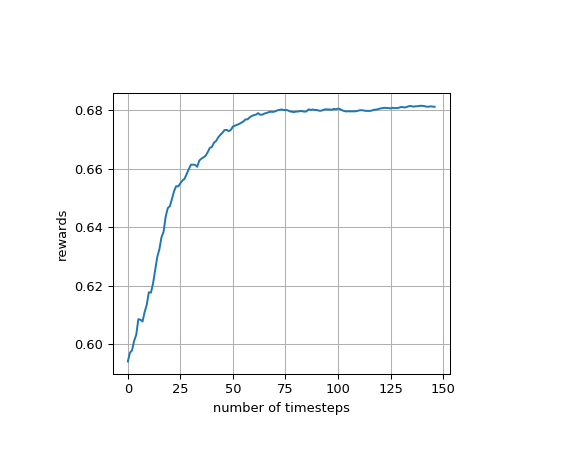

Using cuda device
seed 2: grid fidelity factor 0.25 learning ..
environement grid size (nx x ny ): 15 x 15


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7fbdbc039da0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7fbd64186320>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.60 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.601       |
| time/                   |             |
|    fps                  | 208         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.006082666 |
|    clip_fraction        | 0.373       |
|    clip_range           | 0.1         |
|    entropy_loss         | 92          |
|    explained_variance   | 0.916       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0793      |
|    n_updates            | 2940        |
|    policy_gradient_loss | -0.0273     |
|    std                  | 0.0549      |
|    value_loss           | 0.00287     |
------------

policy iteration runtime: 34 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.62 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.62        |
| time/                   |             |
|    fps                  | 204         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.009740907 |
|    clip_fraction        | 0.336       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.799       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0473      |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0251     |
|    std                  | 

policy iteration runtime: 34 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.64 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.64         |
| time/                   |              |
|    fps                  | 205          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0072204424 |
|    clip_fraction        | 0.345        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.839        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0607       |
|    n_updates            | 320          |
|    policy_gradient_loss | -0.0261      |
|    std 

policy iteration runtime: 38 seconds

Total episode rollouts: 12288

Eval num_timesteps=2560, episode_reward=0.66 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.659        |
| time/                   |              |
|    fps                  | 207          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0075268834 |
|    clip_fraction        | 0.332        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.863        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0676       |
|    n_updates            | 480          |
|    policy_gradient_loss | -0.0254      |
|    std

policy iteration runtime: 39 seconds

Total episode rollouts: 16384

Eval num_timesteps=2560, episode_reward=0.66 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.664        |
| time/                   |              |
|    fps                  | 209          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0064074188 |
|    clip_fraction        | 0.347        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.88         |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0431       |
|    n_updates            | 640          |
|    policy_gradient_loss | -0.0274      |
|    std

policy iteration runtime: 43 seconds

Total episode rollouts: 20480

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.667        |
| time/                   |              |
|    fps                  | 209          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0063805105 |
|    clip_fraction        | 0.337        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.893        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0779       |
|    n_updates            | 800          |
|    policy_gradient_loss | -0.0265      |
|    std                  | 0.

policy iteration runtime: 33 seconds

Total episode rollouts: 24576

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.672       |
| time/                   |             |
|    fps                  | 212         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.004336402 |
|    clip_fraction        | 0.344       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.897       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0759      |
|    n_updates            | 960         |
|    policy_gradient_loss | -0.0275     |
|    std                  |

policy iteration runtime: 38 seconds

Total episode rollouts: 28672

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.676        |
| time/                   |              |
|    fps                  | 210          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0077958107 |
|    clip_fraction        | 0.361        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.902        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.053        |
|    n_updates            | 1120         |
|    policy_gradient_loss | -0.0281      |
|    std

policy iteration runtime: 39 seconds

Total episode rollouts: 32768

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.678       |
| time/                   |             |
|    fps                  | 208         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.005861056 |
|    clip_fraction        | 0.365       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.91        |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0471      |
|    n_updates            | 1280        |
|    policy_gradient_loss | -0.0279     |
|    std                  |

policy iteration runtime: 38 seconds

Total episode rollouts: 36864

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.678       |
| time/                   |             |
|    fps                  | 210         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.005525249 |
|    clip_fraction        | 0.354       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.914       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0463      |
|    n_updates            | 1440        |
|    policy_gradient_loss | -0.0266     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 35 seconds

Total episode rollouts: 40960

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.679        |
| time/                   |              |
|    fps                  | 210          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0050207796 |
|    clip_fraction        | 0.352        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.922        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0582       |
|    n_updates            | 1600         |
|    policy_gradient_loss | -0.0281      |
|    std                  | 0.

policy iteration runtime: 38 seconds

Total episode rollouts: 45056

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.679        |
| time/                   |              |
|    fps                  | 211          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0039938716 |
|    clip_fraction        | 0.36         |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.919        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0473       |
|    n_updates            | 1760         |
|    policy_gradient_loss | -0.0276      |
|    std

policy iteration runtime: 38 seconds

Total episode rollouts: 49152

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.68         |
| time/                   |              |
|    fps                  | 215          |
|    iterations           | 1            |
|    time_elapsed         | 11           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0068958523 |
|    clip_fraction        | 0.37         |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.924        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0566       |
|    n_updates            | 1920         |
|    policy_gradient_loss | -0.0272      |
|    std                  | 0.

policy iteration runtime: 33 seconds

Total episode rollouts: 53248

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.68        |
| time/                   |             |
|    fps                  | 213         |
|    iterations           | 1           |
|    time_elapsed         | 11          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008780968 |
|    clip_fraction        | 0.349       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.918       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0727      |
|    n_updates            | 2080        |
|    policy_gradient_loss | -0.0263     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 38 seconds

Total episode rollouts: 57344

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.68        |
| time/                   |             |
|    fps                  | 210         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.005032888 |
|    clip_fraction        | 0.361       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.927       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0574      |
|    n_updates            | 2240        |
|    policy_gradient_loss | -0.0277     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 33 seconds

Total episode rollouts: 61440

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.68        |
| time/                   |             |
|    fps                  | 210         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007848379 |
|    clip_fraction        | 0.371       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.922       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0665      |
|    n_updates            | 2400        |
|    policy_gradient_loss | -0.0287     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 41 seconds

Total episode rollouts: 65536

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.68         |
| time/                   |              |
|    fps                  | 218          |
|    iterations           | 1            |
|    time_elapsed         | 11           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0066731037 |
|    clip_fraction        | 0.363        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.9         |
|    explained_variance   | 0.924        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0833       |
|    n_updates            | 2560         |
|    policy_gradient_loss | -0.0257      |
|    std                  | 0.

policy iteration runtime: 38 seconds

Total episode rollouts: 69632

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.681       |
| time/                   |             |
|    fps                  | 218         |
|    iterations           | 1           |
|    time_elapsed         | 11          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.006485319 |
|    clip_fraction        | 0.391       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.931       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0462      |
|    n_updates            | 2720        |
|    policy_gradient_loss | -0.0295     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 33 seconds

Total episode rollouts: 73728

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.681       |
| time/                   |             |
|    fps                  | 214         |
|    iterations           | 1           |
|    time_elapsed         | 11          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.005140123 |
|    clip_fraction        | 0.358       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.935       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0661      |
|    n_updates            | 2880        |
|    policy_gradient_loss | -0.0256     |
|    std                  |

<IPython.core.display.Javascript object>


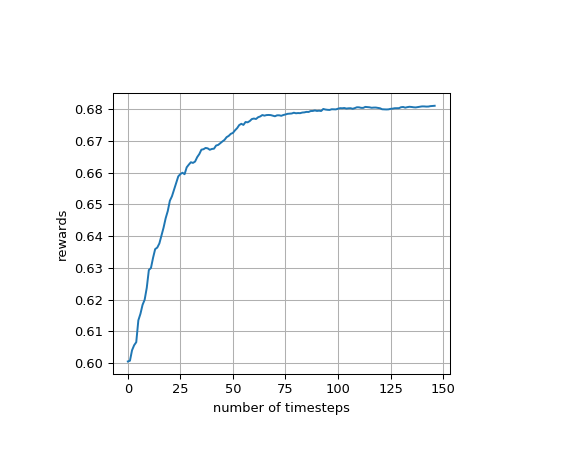

Using cuda device
seed 3: grid fidelity factor 0.25 learning ..
environement grid size (nx x ny ): 15 x 15


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7fbd641ca710> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7fbd503dba20>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.60 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.599       |
| time/                   |             |
|    fps                  | 208         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.006369002 |
|    clip_fraction        | 0.365       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.931       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0599      |
|    n_updates            | 2940        |
|    policy_gradient_loss | -0.0268     |
|    std                  | 0.055       |
|    value_loss           | 0.00245     |
------------

policy iteration runtime: 33 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.62 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.616       |
| time/                   |             |
|    fps                  | 203         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.011970257 |
|    clip_fraction        | 0.356       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.791       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0357      |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0254     |
|    std                  | 

policy iteration runtime: 33 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.63 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.629        |
| time/                   |              |
|    fps                  | 203          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0067400276 |
|    clip_fraction        | 0.334        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.858        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0621       |
|    n_updates            | 320          |
|    policy_gradient_loss | -0.0246      |
|    std 

policy iteration runtime: 34 seconds

Total episode rollouts: 12288

Eval num_timesteps=2560, episode_reward=0.64 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.644        |
| time/                   |              |
|    fps                  | 205          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0075665624 |
|    clip_fraction        | 0.343        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.876        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0725       |
|    n_updates            | 480          |
|    policy_gradient_loss | -0.0253      |
|    std

policy iteration runtime: 40 seconds

Total episode rollouts: 16384

Eval num_timesteps=2560, episode_reward=0.66 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.657        |
| time/                   |              |
|    fps                  | 207          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0007322341 |
|    clip_fraction        | 0.35         |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.9          |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0822       |
|    n_updates            | 640          |
|    policy_gradient_loss | -0.0261      |
|    std

policy iteration runtime: 33 seconds

Total episode rollouts: 20480

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.665       |
| time/                   |             |
|    fps                  | 207         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.011550871 |
|    clip_fraction        | 0.359       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.907       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0637      |
|    n_updates            | 800         |
|    policy_gradient_loss | -0.0269     |
|    std                  |

policy iteration runtime: 39 seconds

Total episode rollouts: 24576

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.671       |
| time/                   |             |
|    fps                  | 209         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.005884564 |
|    clip_fraction        | 0.35        |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.908       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.074       |
|    n_updates            | 960         |
|    policy_gradient_loss | -0.0266     |
|    std                  |

policy iteration runtime: 36 seconds

Total episode rollouts: 28672

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.673        |
| time/                   |              |
|    fps                  | 209          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0038508356 |
|    clip_fraction        | 0.368        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.915        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0626       |
|    n_updates            | 1120         |
|    policy_gradient_loss | -0.0281      |
|    std                  | 0.

policy iteration runtime: 33 seconds

Total episode rollouts: 32768

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.674        |
| time/                   |              |
|    fps                  | 208          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0019762814 |
|    clip_fraction        | 0.364        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.918        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0442       |
|    n_updates            | 1280         |
|    policy_gradient_loss | -0.0286      |
|    std

policy iteration runtime: 34 seconds

Total episode rollouts: 36864

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.676        |
| time/                   |              |
|    fps                  | 212          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0007976681 |
|    clip_fraction        | 0.358        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.921        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0475       |
|    n_updates            | 1440         |
|    policy_gradient_loss | -0.027       |
|    std

policy iteration runtime: 33 seconds

Total episode rollouts: 40960

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.678        |
| time/                   |              |
|    fps                  | 208          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0062909545 |
|    clip_fraction        | 0.361        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.926        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.053        |
|    n_updates            | 1600         |
|    policy_gradient_loss | -0.0282      |
|    std

policy iteration runtime: 33 seconds

Total episode rollouts: 45056

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.679       |
| time/                   |             |
|    fps                  | 213         |
|    iterations           | 1           |
|    time_elapsed         | 11          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008909893 |
|    clip_fraction        | 0.376       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.924       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0785      |
|    n_updates            | 1760        |
|    policy_gradient_loss | -0.0291     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 38 seconds

Total episode rollouts: 49152

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.679       |
| time/                   |             |
|    fps                  | 212         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.006266743 |
|    clip_fraction        | 0.357       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.928       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.052       |
|    n_updates            | 1920        |
|    policy_gradient_loss | -0.0268     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 40 seconds

Total episode rollouts: 53248

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.68         |
| time/                   |              |
|    fps                  | 217          |
|    iterations           | 1            |
|    time_elapsed         | 11           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0056858184 |
|    clip_fraction        | 0.362        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.927        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0583       |
|    n_updates            | 2080         |
|    policy_gradient_loss | -0.0263      |
|    std

policy iteration runtime: 34 seconds

Total episode rollouts: 57344

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.68         |
| time/                   |              |
|    fps                  | 211          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0062673003 |
|    clip_fraction        | 0.352        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.932        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0741       |
|    n_updates            | 2240         |
|    policy_gradient_loss | -0.0274      |
|    std                  | 0.

policy iteration runtime: 33 seconds

Total episode rollouts: 61440

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.68         |
| time/                   |              |
|    fps                  | 203          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0054062577 |
|    clip_fraction        | 0.351        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.9         |
|    explained_variance   | 0.927        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0411       |
|    n_updates            | 2400         |
|    policy_gradient_loss | -0.0261      |
|    std                  | 0.

policy iteration runtime: 36 seconds

Total episode rollouts: 65536

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.68        |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 1           |
|    time_elapsed         | 13          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007933128 |
|    clip_fraction        | 0.374       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.93        |
|    learning_rate        | 3e-06       |
|    loss                 | 0.055       |
|    n_updates            | 2560        |
|    policy_gradient_loss | -0.029      |
|    std                  | 0.055       |
|    va

policy iteration runtime: 38 seconds

Total episode rollouts: 69632

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.681       |
| time/                   |             |
|    fps                  | 203         |
|    iterations           | 1           |
|    time_elapsed         | 12          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.005486223 |
|    clip_fraction        | 0.359       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.939       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0395      |
|    n_updates            | 2720        |
|    policy_gradient_loss | -0.0263     |
|    std                  |

policy iteration runtime: 39 seconds

Total episode rollouts: 73728

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.681        |
| time/                   |              |
|    fps                  | 199          |
|    iterations           | 1            |
|    time_elapsed         | 12           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0075579584 |
|    clip_fraction        | 0.379        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.9         |
|    explained_variance   | 0.936        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0345       |
|    n_updates            | 2880         |
|    policy_gradient_loss | -0.0278      |
|    std

<IPython.core.display.Javascript object>


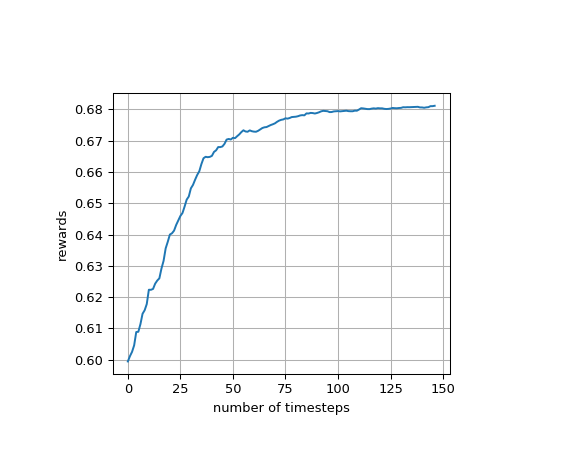

In [7]:
for seed in range(1,4):
    model = multigrid_framework(env_train, 
                                generate_model,
                                generate_callback, 
                                delta_pcent=0.2, 
                                n=np.inf,
                                grid_fidelity_factor_array =[0.25],
                                episode_limit_array=[75000], 
                                log_dir=log_dir,
                                seed=seed)